# HRD Status & PARP Inhibitor Sensitivity Analysis 🔬

**Objective**: Systematically explore the relationship between homologous recombination deficiency (HRD) status and PARP inhibitor response across cell lines and drugs.

---
---
---

## 1. Setup 📦

---

In [134]:
# Data Management
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import ptitprince as pt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# Computational Modules
from scipy.stats import mannwhitneyu, pearsonr, spearmanr, ttest_ind
from sklearn.preprocessing import RobustScaler, StandardScaler

# Utils
from IPython.display import display, HTML, IFrame, Image
from pathlib import Path

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid', {'grid.color':'0.9','xtick.bottom':True,'ytick.left':True})

## 2. Data Loading ⚙️

**Objective**: Load the pickled, analysis-ready datasets containing PARP inhibitor response metrics and HRD features.

---

In [47]:
# Define project root & load analysis-ready dataset
BASE_DIR = Path.cwd()
ccl_hrd_parpi_df = pd.read_pickle(BASE_DIR / 'utils' / 'ccl_hrd_parpi_df.pkl')

ccl_hrd_parpi_df.head(5)

,ModelID,name,auc,HRD_positive,HRD_BRCA,HRD_genomic_score,HRD_genomic,PatientID,CellLineName,StrippedCellLineName,DepmapModelType,OncotreeLineage,OncotreePrimaryDisease,OncotreeSubtype,OncotreeCode,PatientSubtypeFeatures,RRID,Age,AgeCategory,Sex,PatientRace,PrimaryOrMetastasis,SampleCollectionSite,SourceType,SourceDetail,CatalogNumber,ModelType,TissueOrigin,ModelDerivationMaterial,ModelTreatment,PatientTreatmentStatus,PatientTreatmentType,PatientTreatmentDetails,Stage,StagingSystem,PatientTumorGrade,PatientTreatmentResponse,GrowthPattern,OnboardedMedia,FormulationID,SerumFreeMedia,PlateCoating,EngineeredModel,EngineeredModelDetails,CulturedResistanceDrug,PublicComments,CCLEName,HCMIID,PediatricModelType,ModelAvailableInDbgap,ModelSubtypeFeatures,WTSIMasterCellID,SangerModelID,COSMICID,ModelIDAlias
0,ACH-000001,3-amino-benzamide,0.905995,1.0,0.0,0.440492,1.0,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN
1,ACH-000001,S-111,1.000000,1.0,0.0,0.440492,1.0,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN
2,ACH-000001,iniparib,0.914447,1.0,0.0,0.440492,1.0,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN
3,ACH-000001,niraparib,0.741783,1.0,0.0,0.440492,1.0,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN
4,ACH-000001,olaparib,0.916763,1.0,0.0,0.440492,1.0,PT-gj46wT,NIH:OVCAR-3,NIHOVCAR3,HGSOC,Ovary/Fallopian Tube,Ovarian Epithelial Tumor,High-Grade Serous Ovarian Cancer,HGSOC,NaN,CVCL_0465,60.0,Adult,Female,caucasian,Metastatic,ascites,ATCC,NaN,HTB-71,Cell Line,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adherent,MF-001-041,RPMI + 20% FBS + 0.01 mg/ml insulin,False,NaN,NaN,NaN,NaN,NaN,NIHOVCAR3_OVARY,NaN,False,Approved for public sharing - CCLE,NaN,2201.0,SIDM00105,905933.0,NaN


## 3. Cursory Explorations & Preprocessing 🔍

**Objective**: Examine total cell lines, drug coverage, HRD definitions, and other key features to establish a baseline understanding of the engineered dataset and execute any remaining preprocessing steps.

**Methodology**: First, the integrated PARP inhibitor response dataset is loaded and inspected to confirm structural integrity, including dimensions, identifiers, and variable types. Second, redundant, administrative, and highly sparse metadata fields are removed to reduce noise while preserving features with analytical value. Third, cohort composition is characterized by quantifying drug coverage across compounds and within cell lines to evaluate comparability and patterns of missingness. Fourth, baseline response behavior is examined through distributional summaries and dispersion metrics, establishing the scale, variability, and heterogeneity of AUC measurements prior to HRD-stratified analyses.

---

### 3a. Dataset Inspection

In [45]:
ccl_hrd_parpi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6784 entries, 0 to 6796
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ModelID                   6784 non-null   object 
 1   name                      6784 non-null   object 
 2   auc                       6784 non-null   float64
 3   HRD_positive              6784 non-null   float64
 4   HRD_BRCA                  6784 non-null   float64
 5   HRD_genomic_score         6784 non-null   float64
 6   HRD_genomic               6784 non-null   float64
 7   PatientID                 6784 non-null   object 
 8   CellLineName              6784 non-null   object 
 9   StrippedCellLineName      6784 non-null   object 
 10  DepmapModelType           6784 non-null   object 
 11  OncotreeLineage           6784 non-null   object 
 12  OncotreePrimaryDisease    6784 non-null   object 
 13  OncotreeSubtype           6784 non-null   object 
 14  OncotreeCode 

The dataset encompasses 6784 rows, each representing a unique cell line model and PARP inhibitor combination. These records are described by the following feature set:

Cell Line ID & Drug Response Data:
- `ModelID` – unique DepMap identifier for each cell line
- `name` – PARP inhibitor compound name
- `auc` – Area under the curve from PRISM drug response; lower = more sensitive

HRD Status (engineered in the first notebook):
- `HRD_positive` – unified HRD label combining BRCA mutation + genomic scar
- `HRD_BRCA` – BRCA1/2 mutation–defined HRD
- `HRD_genomic_score` – continuous composite genomic scar metric
- `HRD_genomic` – binary genomic scar–derived HRD

Cell Line Metadata:
- `PatientID` – original patient identifier from whom the model was derived
- `CellLineName` / `StrippedCellLineName` / `CCLEName` – names and aliases for the cell line
- `DepmapModelType` / `ModelType` / `EngineeredModel` / `EngineeredModelDetails` – describes how the cell line was derived (e.g., standard, engineered)
- `GrowthPattern` / `OnboardedMedia` / `SerumFreeMedia` / `FormulationID` / `PlateCoating` – experimental or culture conditions

Disease / Tissue Annotation:
- `OncotreeLineage` / `OncotreePrimaryDisease` / `OncotreeSubtype` / `OncotreeCode` – tissue/cancer classification using OncoTree ontology
- `TissueOrigin` – not available in this dataset
- `PatientSubtypeFeatures` / `ModelSubtypeFeatures` – more granular subtype annotations
- `PrimaryOrMetastasis` / `SampleCollectionSite` – whether the tumor is primary or metastatic and collection site

Patient Demographics & Clinical Info:
- `Age` / `AgeCategory` / `Sex` / `PatientRace` – demographics
- `Stage` / `StagingSystem` / `PatientTumorGrade` – tumor stage and grade; mostly missing
- `PatientTreatmentStatus` / `PatientTreatmentType` / `PatientTreatmentDetails` / `PatientTreatmentResponse` – clinical treatment info; sparse

External Identifiers:
- `RRID` / `WTSIMasterCellID` / `SangerModelID` / `COSMICID` / `ModelIDAlias` / `HCMIID` – cross-reference IDs across databases (CCLE, COSMIC, HCMI, Sanger, etc.)

Other:
- `SourceType` / `SourceDetail` / `CatalogNumber` – origin of the sample or vendor info.
- `PublicComments` – notes/comments about the cell line
- `PediatricModelType` – flags pediatric-derived models
- `ModelAvailableInDbgap` – availability for dbGaP access


**Summary**:

- The subset relevant for the primary PARPi-HRD study (the first two feature categories outlined above) is structurally sound and analysis-ready.
- Many patient-level and clinical features are missing and unreliable for further analysis.
- Experimental / culture metadata are mostly complete and therefore may enable adjustment for experimental cofounders.
- Multiple redundant naming/ID columns exist and could be pruned for simplicity. 
- Although HRD status features are all reported as *float64* values, only `HRD_genomic_score` is a continuous variable while the rest are binaries and can be coded accordingly.
- Despite sparse data, model treatment info could be useful as pre-treated models might show a different influence in drug sensitivity. Furthermore, patient subtype features can be used to encode biologically meaningful annotations. So these could be initially kept for further analyses.

### 3b. Feature Pruning

In [48]:
### Perform appropriate cleaning measures based on preliminary inspection above 

# Columns that are entirely or almost entirely missing
mostly_missing_cols = [
    'TissueOrigin',
    'ModelDerivationMaterial',
    'PlateCoating',
    'EngineeredModel',
    'EngineeredModelDetails',
    'CulturedResistanceDrug',
    'StagingSystem',
    'PatientTumorGrade'
]

# Highly sparse clinical/treatment variables (insufficient for analysis)
very_sparse_clinical_cols = [
    'PatientTreatmentStatus',
    'PatientTreatmentType',
    'PatientTreatmentDetails',
    'PatientTreatmentResponse',
    'Stage'
]

# Administrative / vendor / logistics info
administrative_cols = [
    'CatalogNumber',
    'SourceDetail',
    'PublicComments',
    'HCMIID',
    'ModelIDAlias'
]

# Redundant identifiers or naming aliases
redundant_id_cols = [
    'StrippedCellLineName',
]

# Combine drop list
cols_to_drop = (
    mostly_missing_cols
    + very_sparse_clinical_cols
    + administrative_cols
    + redundant_id_cols
)

# Drop irrelevant features (check first, in case of version differences)
cols_to_drop = [col for col in cols_to_drop if col in ccl_hrd_parpi_df.columns]
ccl_hrd_parpi_df = ccl_hrd_parpi_df.drop(columns=cols_to_drop).copy()

To improve analytical reliability and reduce noise, variables with extremely high levels of missingness or no recorded values were removed. Fields that primarily served as redundant identifiers or administrative references were also excluded, since they do not contribute independent biological or pharmacologic information for the present study.

Two sparse attributes (`ModelTreatment` & `PatientSubtypeFeatures`) were intentionally retained despite limited coverage. Although unsuitable for broad statistical modeling, they may contain high-value contextual information capable of explaining unusual response patterns or enabling focused subgroup investigations in future work. Preserving them maintains optionality without affecting the integrity of the primary analyses.

### 3c. Cell Lines & Drug Coverage

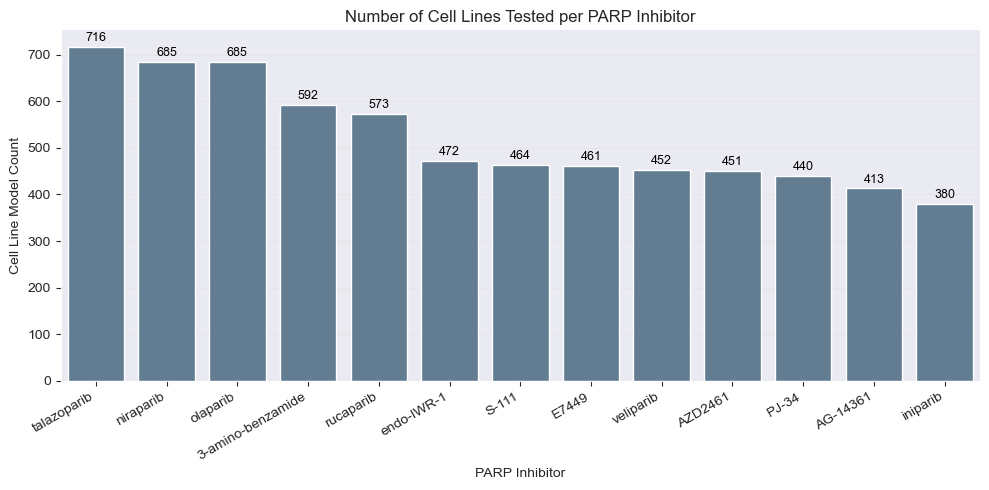

In [117]:
# Set up figure 
plt.figure(figsize=(10, 5))

# Plot number of cells tested per drug
ax = sns.countplot(
    data=ccl_hrd_parpi_df,
    x='name',
    order=(ccl_hrd_parpi_df['name'].value_counts().sort_values(ascending=False).index),
    color='#5A7D9A'
)

# Add count labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        fontsize=9,
        color='black',
        xytext=(0, 2),
        textcoords='offset points'
    )

# Labels and formatting
ax.set_title('Number of Cell Lines Tested per PARP Inhibitor')
ax.set_xlabel('PARP Inhibitor')
ax.set_ylabel('Cell Line Model Count')
plt.xticks(rotation=30, ha='right')
sns.despine()
plt.tight_layout()
plt.show()

Drug representation is uneven across the screening panel. Talazoparib, niraparib, and olaparib were evaluated in the largest number of models, whereas agents such as AG-14361 and iniparib were tested in substantially smaller subsets.

This heterogeneity has practical implications for inference. Compounds with broader coverage provide greater statistical power and more stable effect estimates, while drugs screened in fewer lines may yield noisier comparisons and reduced sensitivity for detecting HRD-associated differences. As a result, both pooled and drug-specific analyses should consider sample size variability.

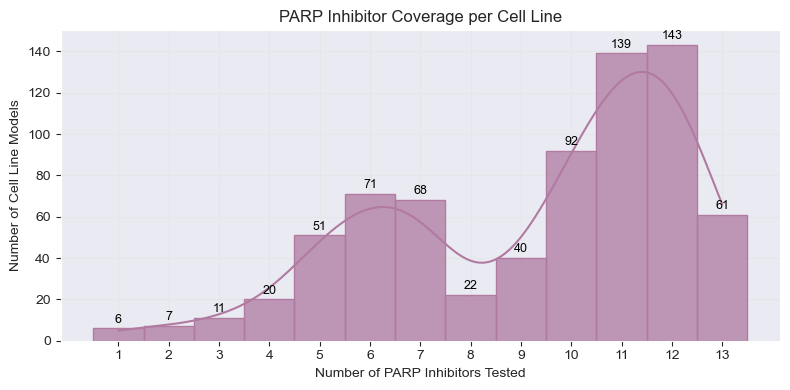

In [118]:
# Set up figure
plt.figure(figsize=(8, 4))

# Histogram with integer-aligned bins
ax = sns.histplot(
    data=drug_counts,
    x='drug_count',
    bins=np.arange(0.5, 14.5, 1),
    stat='count',
    color='#B07AA1',
    kde=True,
    edgecolor='#B07AA1',
    alpha=0.75
)

# Add count labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='bottom',
        fontsize=9,
        color='black',
        xytext=(0, 2),
        textcoords='offset points'
    )

        
# Labels and formatting
plt.title('PARP Inhibitor Coverage per Cell Line')
plt.xlabel('Number of PARP Inhibitors Tested')
plt.ylabel('Number of Cell Line Models')
plt.xticks(range(int(drug_counts['drug_count'].min()),
                 int(drug_counts['drug_count'].max()) + 1))
plt.tight_layout()
plt.show()

The distribution of the number of unique PARP inhibitors tested per cell line is shown above. Because drug coverage is a discrete integer quantity, the histogram was constructed with one bin per compound, allowing direct interpretation of screening depth. Most cell lines were profiled against a large fraction of the PARP inhibitor panel. The distribution is distinctly bimodal, with a dominant concentration of models tested against approximately 10–12 compounds and a secondary cluster evaluated across a more limited subset (roughly 5–7 inhibitors). Only a small number of models exhibit very low coverage, resulting in a sparse low-coverage tail.

This structure suggests that cross-drug comparisons are generally feasible. Cell lines with high screening coverage support within-model comparisons of relative drug sensitivity, whereas partially profiled models may introduce additional missingness or variance in drug-specific analyses. Accordingly, downstream modeling may benefit from sensitivity analyses that restrict to broadly screened cell lines to confirm the robustness of observed associations. It is important to note that, 61 cell line models were screened for all 13 PARP inhibitors available in the dataset, enabling potential within-model comparisons across the drugs.

### 3d. HRD Landscape Across the Screen

##### Overall HRD Prevalence By Definition

HRD_positive    0.853626
HRD_genomic     0.835200
HRD_BRCA        0.061616
dtype: float64


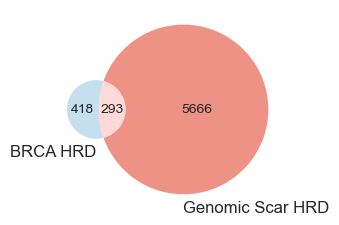

In [145]:
# Proportion of models in each HRD definition
hrd_summary = (
    ccl_hrd_parpi_df[['HRD_positive', 'HRD_BRCA', 'HRD_genomic']]
    .mean()
    .sort_values(ascending=False)
)
print(hrd_summary)

# Visualize overlap between both HRD definitions
plt.figure(figsize=(3,3))
venn2(
    subsets=(ccl_hrd_parpi_df['HRD_BRCA'].astype(bool).sum(), ccl_hrd_parpi_df['HRD_genomic'].astype(bool).sum(), 
             (ccl_hrd_parpi_df['HRD_BRCA'].astype(bool) & ccl_hrd_parpi_df['HRD_genomic'].astype(bool)).sum()),
    set_labels=('BRCA HRD', 'Genomic Scar HRD'),
    set_colors=('#9ECAE1', '#E24A33'),
    alpha=0.6
)
plt.show()

This table summarizes the prevalence of homologous recombination deficiency (HRD) across different operational definitions. The unified HRD label (`HRD_positive`) captures the largest fraction of models (85.4%) because it combines BRCA mutation–driven and genomic scar–based evidence. The genomic classifier alone (`HRD_genomic`) identifies a similarly broad set of candidates (83.5%), while BRCA mutation–defined HRD (`HRD_BRCA`) represents a smaller, highly specific subset (6.2%).

Quantifying these proportions is critical for downstream analyses. Class balance directly affects statistical power, variance, and effect estimation in comparative and predictive modeling. The large size of the HRD-positive group suggests that broad comparisons will be feasible, though careful consideration of subgroup heterogeneity may be warranted.

##### BRCA vs Genomic HRD Concordance

In [138]:
# Crosstab of the two HRD mechanisms
concordance_table = pd.crosstab(
    ccl_hrd_parpi_df['HRD_BRCA'],
    ccl_hrd_parpi_df['HRD_genomic'],
    rownames=['BRCA'],
    colnames=['Genomic']
)

concordance_table

Genomic,0.0,1.0
BRCA,,
0.0,993,5373
1.0,125,293


This contingency table compares HRD cells derived from BRCA mutations (`HRD_BRCA`) and the genomic scar classifier (`HRD_genomic`). Concordant classifications indicate consistent biological signals of homologous recombination deficiency, while discordant cases suggest alternative mechanisms of pathway disruption or residual genomic scars independent of BRCA status.

Notably, the genomic-only group (BRCA–negative / genomic–positive) highlights the additional models captured by the composite scar score, demonstrating the value of incorporating both mutation and genomic evidence for more comprehensive HRD detection.

##### HRD Frequency by Cancer Lineage

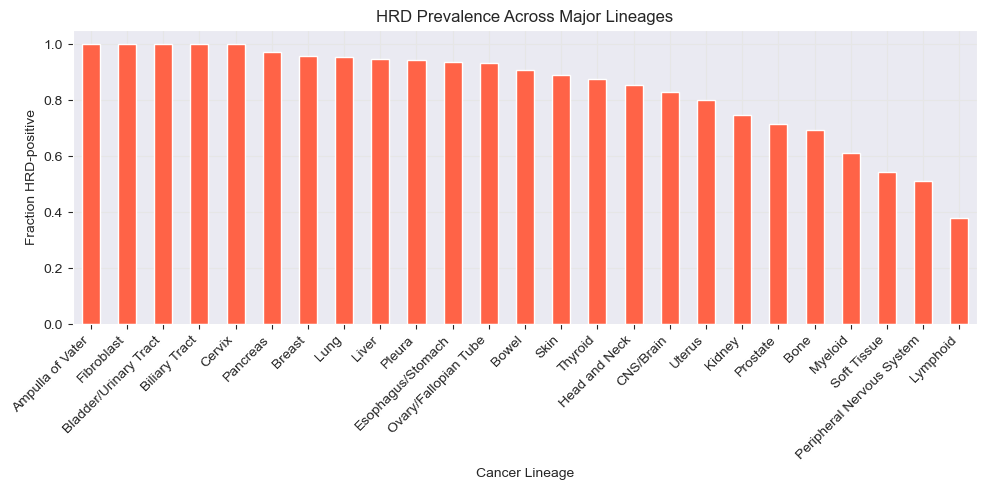

In [159]:
lineage_hrd = (
    ccl_hrd_parpi_df
    .groupby('OncotreeLineage')['HRD_positive']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
ax = lineage_hrd.plot(kind='bar', color='tomato')

plt.title('HRD Prevalence Across Major Lineages')
plt.ylabel('Fraction HRD-positive')
plt.xlabel('Cancer Lineage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


The plot above shows the fraction of cell line models classified as HRD-positive across major cancer lineages. HR deficiency is generally high, with most tissues above 85%, but there is notable variation. Lineages such as Ampulla of Vater, Fibroblast, Bladder/Urinary Tract, Biliary Tract, and Cervix are uniformly HRD-positive, while others, including Lymphoid, Peripheral Nervous System, Soft Tissue, and Myeloid, exhibit substantially lower prevalence.

Examining lineage-specific prevalence is important because overrepresentation of HRD-positive models in certain tissues could confound downstream analyses. Naive comparisons of PARP inhibitor response might partly reflect tissue-specific biology rather than homologous recombination deficiency itself.

Future modeling should account for this imbalance by including lineage as a covariate, performing stratified analyses, or limiting comparisons to lineages with sufficient representation. Doing so ensures that observed associations between HRD status and PARPi sensitivity reflect true repair deficiency rather than tissue composition effects.

### 3e. Drug Response Metric (AUC) Characteristics

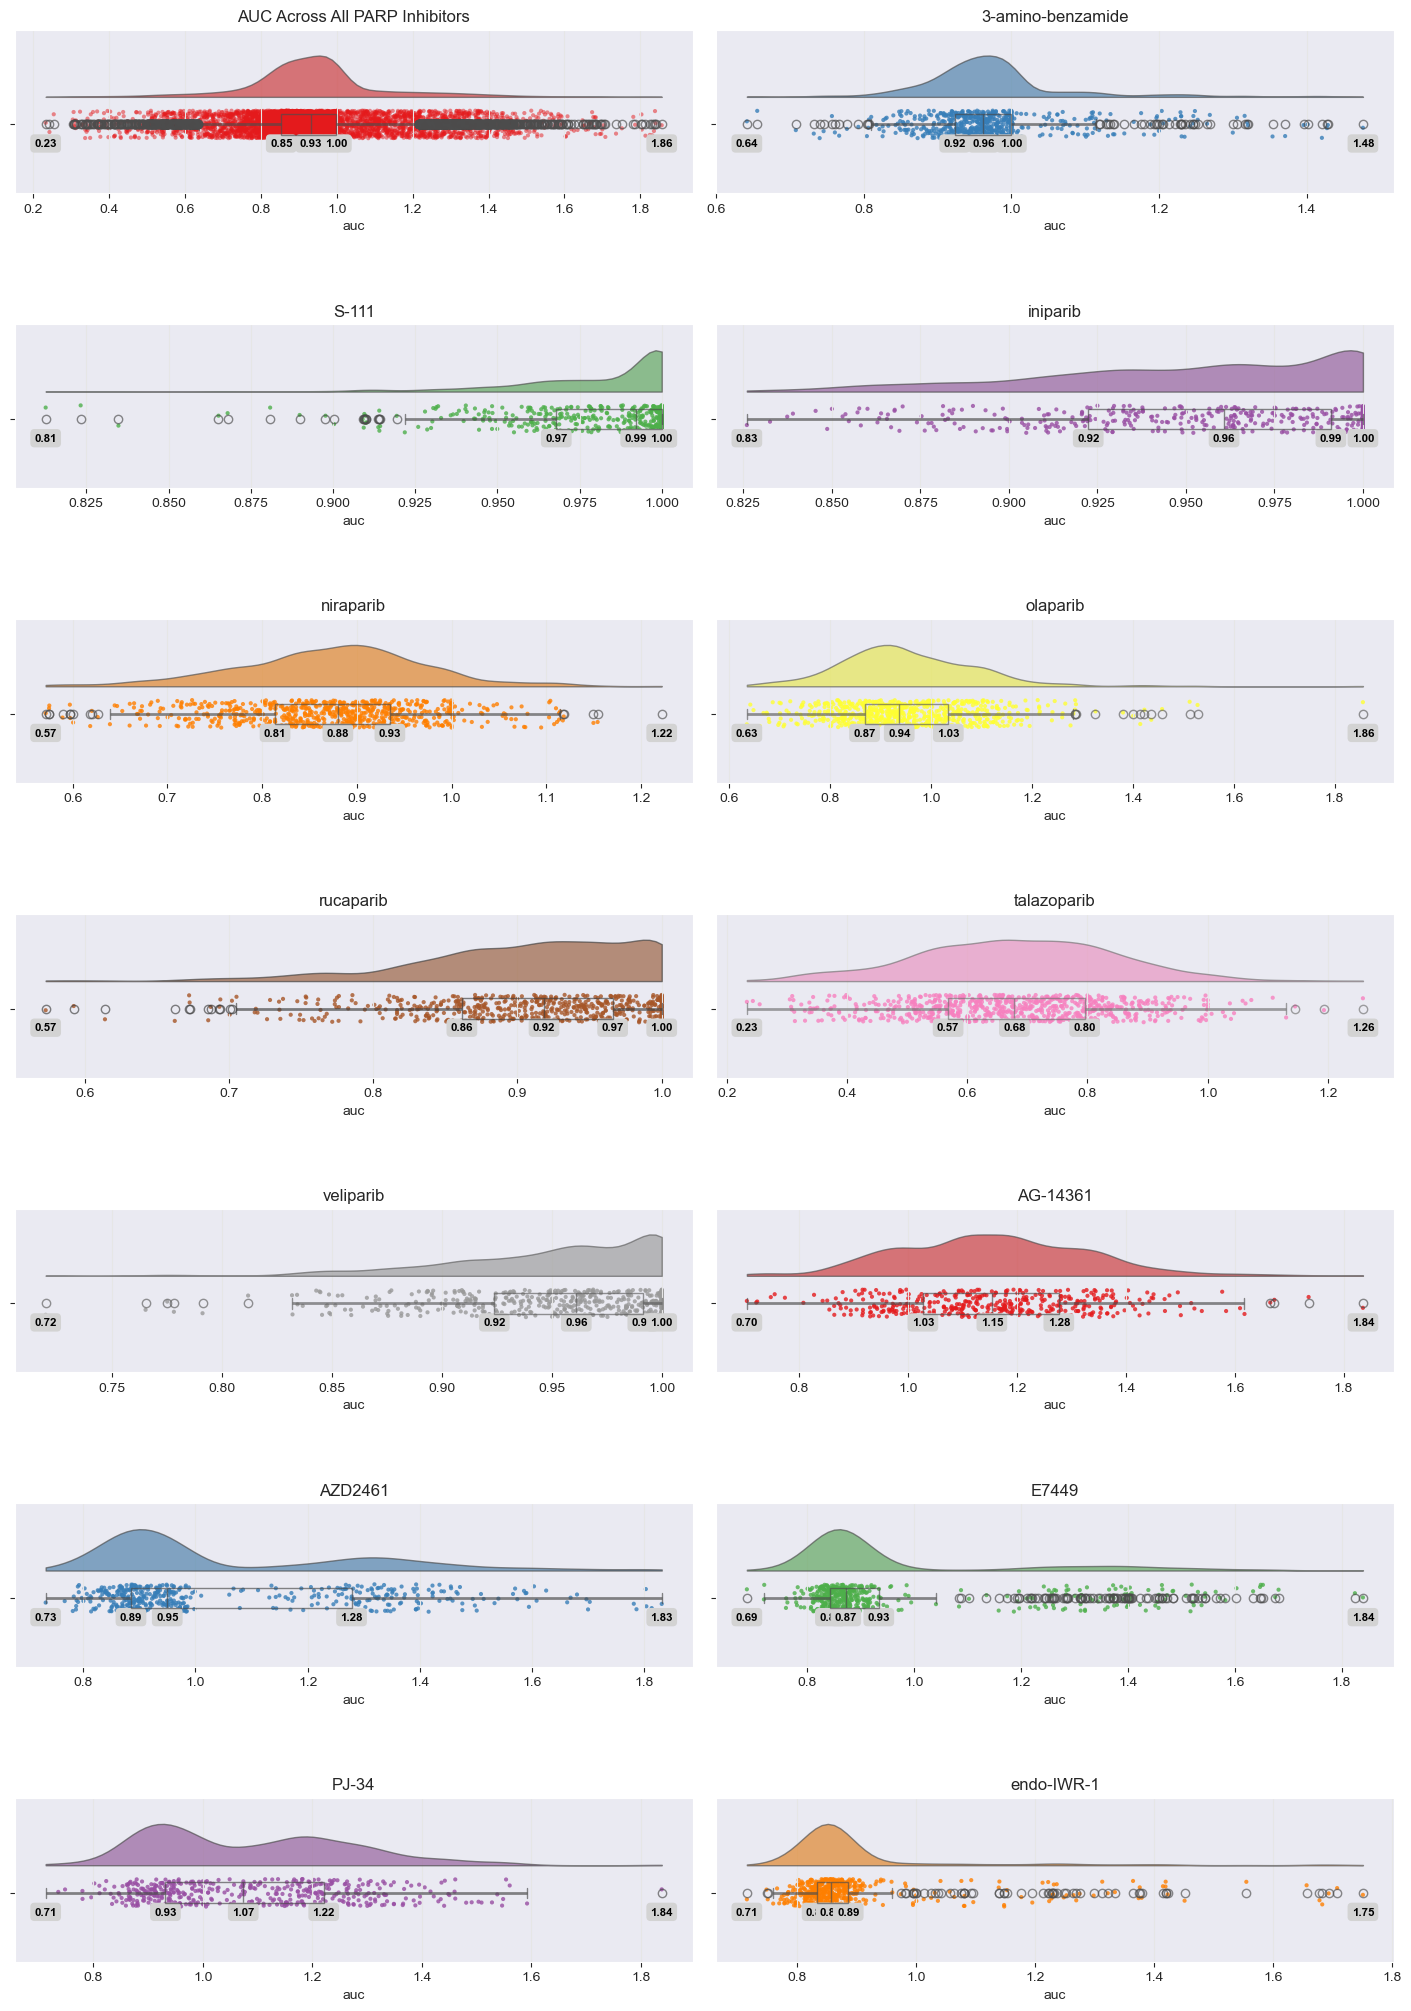

In [202]:
# Set up figure & individual subplots
fig, axs = plt.subplots(7, 2, figsize=(14, 20), 
    layout='constrained', gridspec_kw={'hspace': 0.25})
axs = axs.flatten()  # for easy indexing
rc_palettes = sns.color_palette('Set1', n_colors=14)

# Plot AUCs across all drugs
cloud_all = pt.RainCloud(
    data=ccl_hrd_parpi_df,
    y='auc',
    bw=0.2,
    alpha=0.65,
    rain_alpha=0.5,
    width_viol=0.6,
    orient='h',
    palette=[rc_palettes[0]],
    hue=0,
    ax=axs[0],
)

# Add quartile labels
desc_stats = ccl_hrd_parpi_df['auc'].quantile([0, 0.25, 0.5, 0.75, 1])
for stat in desc_stats:
    cloud_all.text(
        s=f"{stat:.2f}",
        x=stat,
        y=0.16,
        ha='center',
        size='small',
        color='black',
        weight='semibold',
        bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
    )
axs[0].set_title('AUC Across All PARP Inhibitors')

# Plot AUCs for each drug
drug_list = ccl_hrd_parpi_df['name'].unique()
for i, drug in enumerate(drug_list):
    
    # Subset for specific drug
    drug_data = ccl_hrd_parpi_df[ccl_hrd_parpi_df['name'] == drug]

    # Raincloud
    cloud = pt.RainCloud(
        data=drug_data,
        y='auc',
        bw=0.2,
        alpha=0.65,
        rain_alpha=0.8,
        width_viol=0.6,
        orient='h',
        hue=i,
        palette=[rc_palettes[i+1]],
        ax=axs[i+1],
    )

    # Add quartile labels
    desc_stats = drug_data['auc'].quantile([0, 0.25, 0.5, 0.75, 1])
    for stat in desc_stats:
        cloud.text(
            s=f"{stat:.2f}",
            x=stat,
            y=0.16,
            ha='center',
            size='small',
            color='black',
            weight='semibold',
            bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
        )
    axs[i+1].set_title(drug)

plt.show()

PRISM AUC distributions for all PARP inhibitors and pooled across compounds. Lower AUC indicates higher sensitivity. The aggregated distribution is unimodal around 0.9–1.1, with a moderate right tail. Stratified by drug, several compounds (S-111, Veliparib, Iniparib) show tightly clustered responses, while others (AG-14361, PJ-34, Endo-IWR-1) are more dispersed with resistant outliers. Talazoparib displays stronger sensitivity (left-shifted), and AZD2461/E7449 suggest multimodal patterns, potentially reflecting biologically distinct subgroups. These differences in median, variance, and tail structure highlight that PARP inhibitors are not interchangeable and underscore the need for HRD-stratified analyses.

**NOTE**: PRISM AUC values are not constrained to the unit interval. Values greater than 1 arise from the curve-fitting and normalization procedures used in the PRISM pipeline and typically reflect relative resistance or growth advantage under treatment rather than a probabilistic bound. Because baseline distributions differ by compound, later analyses will incorporate drug-aware normalization strategies to enable fair cross-drug comparisons and prevent scale-driven artifacts in effect estimation.

In [210]:
### Drug Response Dispersion Table

# Group by drug and compute variability metrics
drug_dispersion_df = (
    ccl_hrd_parpi_df
    .groupby('name')['auc']
    .agg(
        n_models='count',
        mean_auc='mean',
        std_auc='std',
        min_auc='min',
        max_auc='max'
    )
)

# Compute coefficient of variation
drug_dispersion_df['cv'] = drug_dispersion_df['std_auc'] / drug_dispersion_df['mean_auc']

# Apply a robust dynamic range (less sensitive to extreme outliers)
percentiles = (
    ccl_hrd_parpi_df
    .groupby('name')['auc']
    .quantile([0.05, 0.95])  # for initial explorations
    .unstack()
    .rename(columns={0.05: 'p05', 0.95: 'p95'})
)

drug_dispersion_df = drug_dispersion_df.join(percentiles)
drug_dispersion_df['dynamic_range_95_5'] = (
    drug_dispersion_df['p95'] - drug_dispersion_df['p05']
)

# Rank by separation ability
drug_dispersion_df = drug_dispersion_df.sort_values(
    by='dynamic_range_95_5',
    ascending=False
)

drug_dispersion_df.round(3)

,n_models,mean_auc,std_auc,min_auc,max_auc,cv,p05,p95,dynamic_range_95_5
name,,,,,,,,,
AZD2461,451,1.067,0.246,0.733,1.831,0.230,0.822,1.537,0.715
E7449,461,0.976,0.229,0.687,1.840,0.235,0.810,1.474,0.664
PJ-34,440,1.090,0.186,0.713,1.839,0.170,0.860,1.422,0.563
AG-14361,413,1.156,0.176,0.703,1.836,0.152,0.891,1.442,0.551
talazoparib,716,0.681,0.166,0.233,1.258,0.243,0.395,0.940,0.545
endo-IWR-1,472,0.900,0.154,0.715,1.751,0.171,0.794,1.250,0.456
olaparib,685,0.954,0.138,0.634,1.856,0.144,0.758,1.172,0.415
3-amino-benzamide,592,0.975,0.104,0.642,1.476,0.107,0.849,1.199,0.350
niraparib,685,0.873,0.100,0.571,1.222,0.115,0.701,1.032,0.331


The table quantifies how response variability differs across PARP inhibitors, revealing several important patterns.

First, dispersion is highly uneven across compounds. AZD2461 and E7449 show the largest variability, with high standard deviations, wide 5–95% ranges, and large coefficients of variation. Talazoparib also exhibits substantial spread but is globally left-shifted, reflecting stronger overall sensitivity despite heterogeneity across models.

In contrast, veliparib, iniparib, and S-111 have extremely compressed distributions. Their dynamic ranges are narrow, percentile spreads are small, and maximum AUC values frequently approach the assay ceiling. This limited separation between sensitive and resistant models may reduce statistical power in downstream analyses.

Second, central tendencies differ meaningfully. Some compounds, such as AG-14361 and PJ-34, are right-shifted toward higher AUCs, indicating weaker average activity, whereas others, notably talazoparib and niraparib, trend toward lower medians.

Finally, the percentile-based dynamic range is particularly informative. By focusing on the 5th–95th percentiles, it minimizes the influence of extreme outliers while capturing the effective response window for most cell lines.

Overall, these results reinforce a key message from the visualizations: PARP inhibitors differ widely in both potency and discriminatory capacity. Any cross-drug comparison or pooled analysis must account for compound-specific scaling and variance structure.

for readme version later:
PARP inhibitors vary widely in potency and response variability. AZD2461 and E7449 show the largest spread across models, while Talazoparib is generally more potent but heterogeneous. Veliparib, Iniparib, and S-111 have narrow distributions, limiting separation of sensitive vs resistant lines. The 5th–95th percentile range highlights these differences while minimizing outlier influence, emphasizing that cross-drug comparisons must account for compound-specific variance.

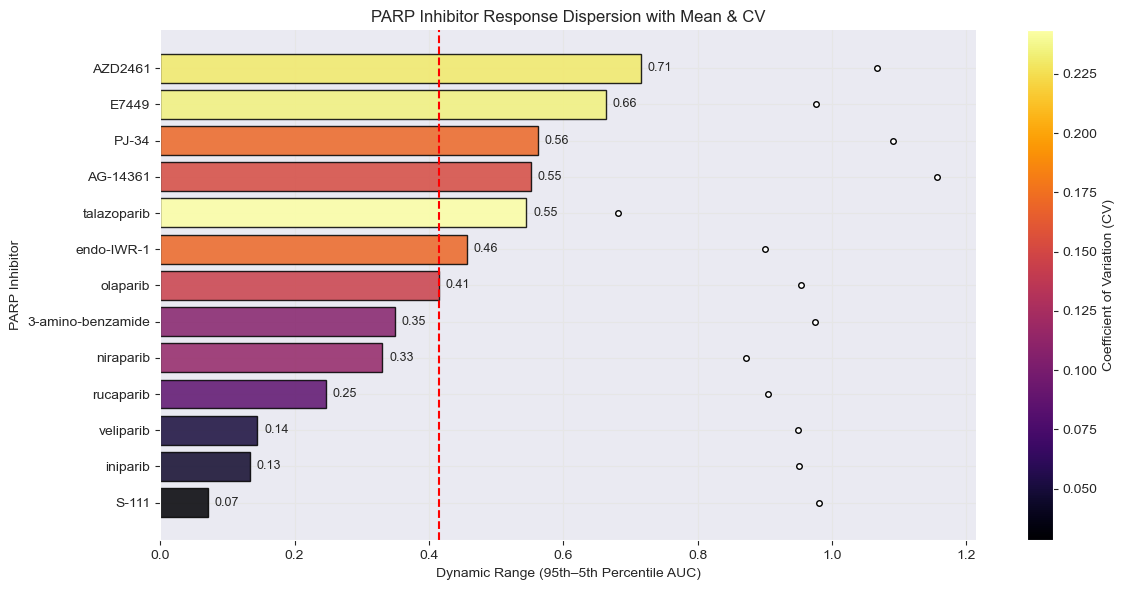

In [224]:
# Set up figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Normalize CV for color mapping
norm = plt.Normalize(drug_dispersion_df['cv'].min(), drug_dispersion_df['cv'].max())
cmap = plt.cm.inferno

# Bar plot with CV-based colors
bars = ax.barh(
    y=drug_dispersion_df.index,
    width=drug_dispersion_df['dynamic_range_95_5'],
    color=cmap(norm(drug_dispersion_df['cv'])),
    edgecolor='black',
    alpha=0.85
)

# Overlay mean AUC as a dot
for i, drug in enumerate(drug_dispersion_df.index):
    ax.plot(
        drug_dispersion_df.loc[drug, 'mean_auc'],
        i,
        'o',
        color='white',
        markersize=4,
        markeredgecolor='black'
    )

# Add numeric labels for dynamic range
for i, v in enumerate(drug_dispersion_df['dynamic_range_95_5']):
    ax.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=9)

# Add vertical line for median dynamic range
median_range = drug_dispersion_df['dynamic_range_95_5'].median()
ax.axvline(median_range, color='red', linestyle='--', linewidth=1.5, label=f'Median Range ({median_range:.2f})')

# Labels and formatting
ax.set_xlabel('Dynamic Range (95th–5th Percentile AUC)')
ax.set_ylabel('PARP Inhibitor')
ax.set_title('PARP Inhibitor Response Dispersion with Mean & CV')
ax.invert_yaxis()  # largest range on top
sns.despine(ax=ax)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Coefficient of Variation (CV)')

plt.tight_layout()
plt.show()

This visualization compares the effective response window of each PARP inhibitor using the 5th–95th percentile AUC range. Bar length reflects separation between sensitive and resistant models, color encodes relative variability (coefficient of variation), and the white point marks the mean response.

Compounds such as AZD2461 and E7449 display broad ranges and high dispersion, whereas S-111, Veliparib, and Iniparib show compressed activity with limited contrast. The median reference line indicates which drugs provide above- or below-typical discriminatory spread, emphasizing that variability differs substantially across inhibitors.

## 4. Relationship Between HRD & PARP Inhibitor Sensitivity 🔬

**Objective**: 

**Methodology**: 

---

##### Global Comparison

##### Per-Drug Comparison

##### HRD Definition Comparison

##### Continuous Signal

### PARP inhibitor mechanisms and trapping potency (also drug info)

 high-credibility summary of each compound with:

clinical status

relative trapping strength

anything unusual